In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

In [3]:
friedman2 = requests.get('https://www.stata-press.com/data/r12/friedman2.dta').content
data = pd.read_stata(BytesIO(friedman2))
data.index = data.time
data.index.freq = "QS-OCT"

# Variables
endog = data.loc['1959':'1981', 'consump']
exog = sm.add_constant(data.loc['1959':'1981', 'm2'])

# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(1,0,1))
res = mod.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                consump   No. Observations:                   92
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -340.508
Date:                Thu, 28 Apr 2022   AIC                            691.015
Time:                        12:29:34   BIC                            703.624
Sample:                    01-01-1959   HQIC                           696.105
                         - 10-01-1981                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -36.0608     56.643     -0.637      0.524    -147.078      74.957
m2             1.1220      0.036     30.825      0.000       1.051       1.193
ar.L1          0.9348      0.041     22.717      0.0

In [4]:
data.tail(15)

,m2,time,m1,consump,pc92
time,,,,,
1995-01-01,3506.330078,1995-01-01,1146.619995,4862.500000,4555.299805
1995-04-01,3564.590088,1995-04-01,1142.640015,4931.500000,4593.600098
1995-07-01,3618.149902,1995-07-01,1141.430054,4986.399902,4623.399902
1995-10-01,3651.239990,1995-10-01,1128.680054,5035.299805,4650.000000
1996-01-01,3709.949951,1996-01-01,1125.260010,5108.200195,4692.100098
1996-04-01,3743.360107,1996-04-01,1116.060059,5199.000000,4746.600098
1996-07-01,3774.590088,1996-07-01,1094.760010,5242.500000,4768.299805
1996-10-01,3826.080078,1996-10-01,1082.849976,5313.200195,4802.600098
1997-01-01,3869.659912,1997-01-01,1074.959961,5402.399902,4853.399902


In [5]:
exog

,const,m2
time,,
1959-01-01,1.0,289.149994
1959-04-01,1.0,294.049988
1959-07-01,1.0,296.730011
1959-10-01,1.0,297.799988
1960-01-01,1.0,299.350006
...,...,...
1980-10-01,1.0,1601.099976
1981-01-01,1.0,1638.000000
1981-04-01,1.0,1670.550049


In [6]:
endog

time
1959-01-01     310.399994
1959-04-01     316.399994
1959-07-01     321.700012
1959-10-01     323.799988
1960-01-01     327.299988
                 ...     
1980-10-01    1836.800049
1981-01-01    1890.300049
1981-04-01    1923.500000
1981-07-01    1967.400024
1981-10-01    1983.900024
Freq: QS-OCT, Name: consump, Length: 92, dtype: float32

## in our case

In [7]:
df=pd.read_csv("data/train.csv")

In [8]:
# Feature 
df['vol'] = df['time_step'] * df['u_in']
#df['vol'] = df.query('u_out==0').groupby('breath_id')['vol'].cumsum()
df['vol'] = df.groupby('breath_id')['vol'].cumsum()
df['rtime']=df['time_step'].apply(lambda x: round(x,3))
df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
df['minus_one']=-1.0
df['plus_one']=1.0
df['exponent']=(df['minus_one']*df['time_step'])/(df['R']*df['C'])
df['factor']=np.exp(df['exponent'])
df['vf']=(df['u_in_cumsum']*df['R'])/df['factor']
df['vt']=0
df.loc[df['time_step'] != 0, 'vt']=df['vol']/(df['C']*(df['minus_one']*df['factor']+df['plus_one']))
df['v']=df['vf']+df['vt']
df['step_id']=df.id.apply(lambda x: x%80)
df=df.drop(['minus_one', 'plus_one', 'u_in_cumsum'], axis=1)
#df=df.query('u_out==0')

#cols=['v','u_in_cumsum','vol','pressure', 'u_in', 'R', 'C', 'time_step',"step_id"]
#red_df=df[cols]
#red_df=pd.get_dummies(data=df, columns=['R','C', 'step_id'],drop_first=True)

In [9]:
#first_breath=df.query('breath_id<10')

In [10]:
cols=['v','vol','pressure', 'u_in', 'R', 'C', 'time_step',"step_id", 'id', 'breath_id']
data = df.query('breath_id<20')[cols]

#X_train, X_test, y_train, y_test = train_test_split(data.drop('pressure',axis=1), data.pressure, test_size=0.33, random_state=42)
splitbreath = 19
splitpoint = 1280

# calculate splitpoint by breath
#print(data.breath_id.max())
splitpoint = data[data['breath_id']==data.breath_id.max()].id.min()

data_train, data_test = data.loc[:splitpoint], data.loc[splitpoint:]
X_train, y_train = data_train.drop('pressure', axis=1), data_train.pressure
X_test, y_test = data_test.drop('pressure', axis=1), data_train.pressure

In [11]:
#friedman2 = requests.get('https://www.stata-press.com/data/r12/friedman2.dta').content
#data = pd.read_stata(BytesIO(friedman2))

#X_train.index = X_train.id
#red_df.index.freq = "QS-OCT"

# Variables
endog = y_train
#exog = sm.add_constant(first_breath[['u_in', 'vol']])
exog = X_train

# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog.loc[:1280], exog.loc[:1280], order=(1,0,1))
res = mod.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:               pressure   No. Observations:                 1281
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -2318.464
Date:                Thu, 28 Apr 2022   AIC                           4660.928
Time:                        12:29:45   BIC                           4722.793
Sample:                             0   HQIC                          4684.157
                               - 1281                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
v              0.0002   4.21e-05      3.792      0.000    7.71e-05       0.000
vol            0.0083      0.001      6.365      0.000       0.006       0.011
u_in          -0.0467      0.009     -5.117      0.0

In [12]:
#predict = res.get_prediction(df.query('breath_id==2').time_step.apply(lambda x: x%80))
#predict = res.get_prediction(df.query('breath_id==2').reset_index(drop=True).index)
predict = res.get_prediction()
predict_ci = predict.conf_int()
#predict_dy = res.predict(start=1280, end=1360, exog=X_test)
predict_dy = res.predict(start=1281, end=1310, exog=X_test)
#predict_dy_ci = predict_dy.conf_int()

ValueError: Provided exogenous values are not of the appropriate shape. Required (30, 9), got (79, 9).

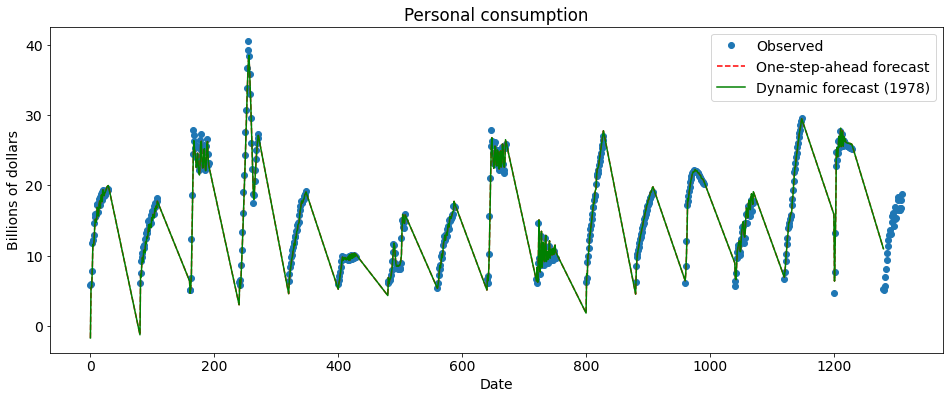

In [ ]:
fig, ax = plt.subplots(figsize=(16,6))
npre = 4
ax.set(title='Personal consumption', xlabel='Date', ylabel='Billions of dollars')

# Plot data points
data.pressure.plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.plot(ax=ax, style='r--', label='One-step-ahead forecast')
#ci = predict_ci.time_step
#ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.plot(ax=ax, style='g', label='Dynamic forecast (1978)')
#ci = predict_dy_ci.loc['1977-07-01':]
#ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='upper right')

### by index

In [3]:
df=pd.read_csv("data/train.csv")

In [4]:
# Feature 
df['vol'] = df['time_step'] * df['u_in']
#df['vol'] = df.query('u_out==0').groupby('breath_id')['vol'].cumsum()
df['vol'] = df.groupby('breath_id')['vol'].cumsum()
df['rtime']=df['time_step'].apply(lambda x: round(x,3))
df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
df['minus_one']=-1.0
df['plus_one']=1.0
df['exponent']=(df['minus_one']*df['time_step'])/(df['R']*df['C'])
df['factor']=np.exp(df['exponent'])
df['vf']=(df['u_in_cumsum']*df['R'])/df['factor']
df['vt']=0
df.loc[df['time_step'] != 0, 'vt']=df['vol']/(df['C']*(df['minus_one']*df['factor']+df['plus_one']))
df['v']=df['vf']+df['vt']
df['step_id']=df.id.apply(lambda x: x%80)
df=df.drop(['minus_one', 'plus_one', 'u_in_cumsum'], axis=1)
#df=df.query('u_out==0')

#cols=['v','u_in_cumsum','vol','pressure', 'u_in', 'R', 'C', 'time_step',"step_id"]
#red_df=df[cols]
#red_df=pd.get_dummies(data=df, columns=['R','C', 'step_id'],drop_first=True)

In [5]:
cols=['v','vol','pressure', 'u_in', 'R', 'C', 'time_step',"step_id", 'id', 'breath_id']
#data = df.query('breath_id<60000')[cols]
data = df[cols].query('breath_id<80')
data = data.reset_index(drop=True)

splitpoint = data.query('breath_id==79').index.min()
end_point = data.query('breath_id==79').index.max()

# calculate splitpoint by breath
#print(data.breath_id.max())
#splitpoint = data[data['breath_id']==data.breath_id.max()].id.min()

data_train, data_test = data.loc[:splitpoint], data.loc[splitpoint:]
X_train, y_train = data_train.drop('pressure', axis=1), data_train.pressure
X_test, y_test = data_test.drop('pressure', axis=1), data_test.pressure

In [8]:
X_train.loc[70:90]

,v,vol,u_in,R,C,time_step,step_id,id,breath_id
70,19777.222101,523.969514,4.940237,20,50,2.383458,71,71,1
71,19914.081536,535.935445,4.949604,20,50,2.417553,72,72,1
72,20051.922720,548.088541,4.957466,20,50,2.451473,73,73,1
73,20190.020930,560.427331,4.964136,20,50,2.485587,74,74,1
74,20329.016887,572.948573,4.969730,20,50,2.519502,75,75,1
75,20468.195657,585.651356,4.974474,20,50,2.553593,76,76,1
76,20607.714156,598.534439,4.978481,20,50,2.587754,77,77,1
77,20747.898480,611.595714,4.981847,20,50,2.621773,78,78,1
78,20888.548390,624.833765,4.984683,20,50,2.655746,79,79,1
79,21029.468857,638.247842,4.987079,20,50,2.689766,0,80,1


In [70]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

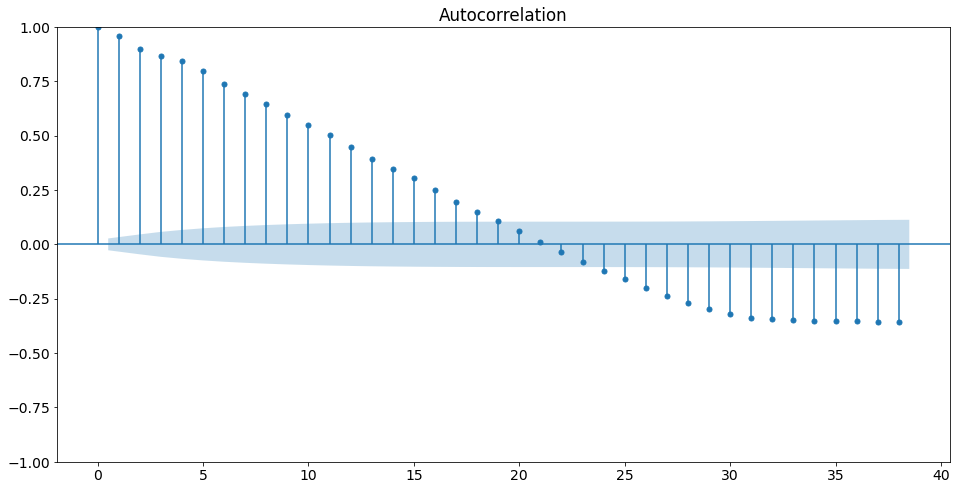

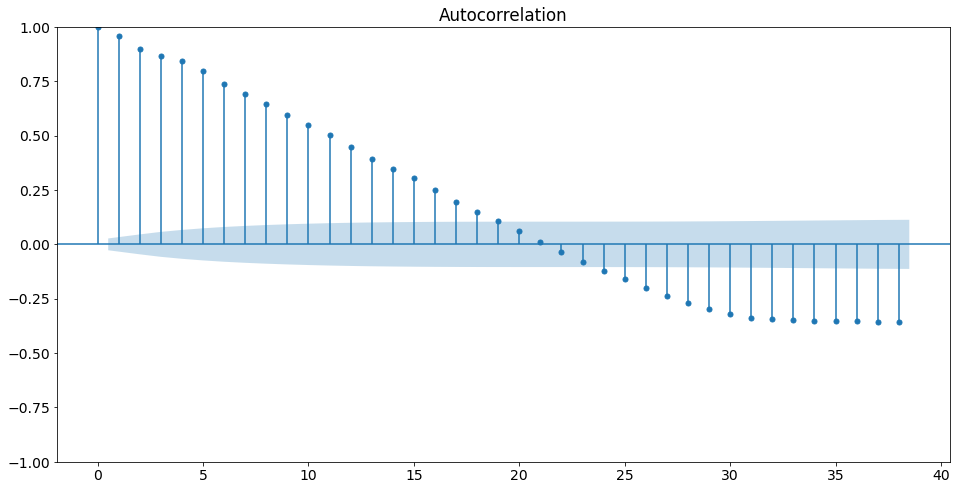

In [43]:
plot_acf(data.pressure)

In [1]:
plot_acf(difference(data.pressure,1))

NameError: name 'plot_acf' is not defined

/Users/martin/Projects/CapStone/.venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


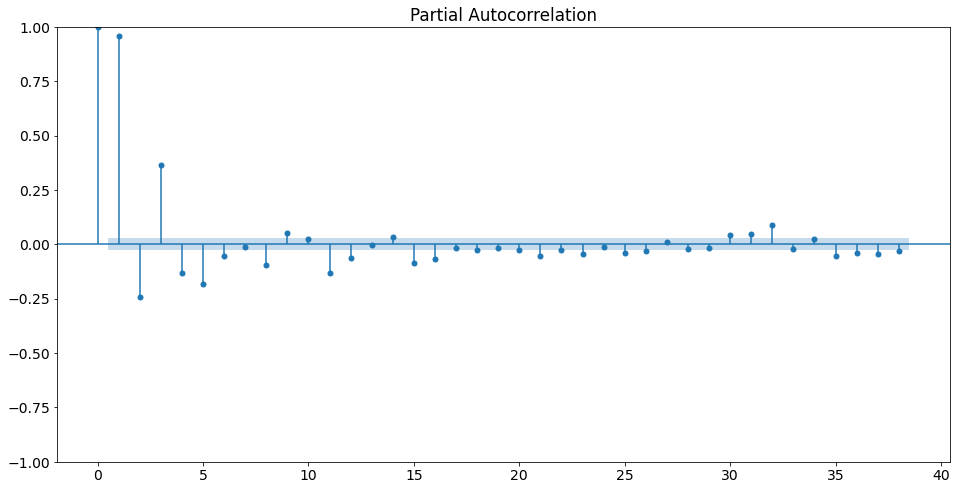

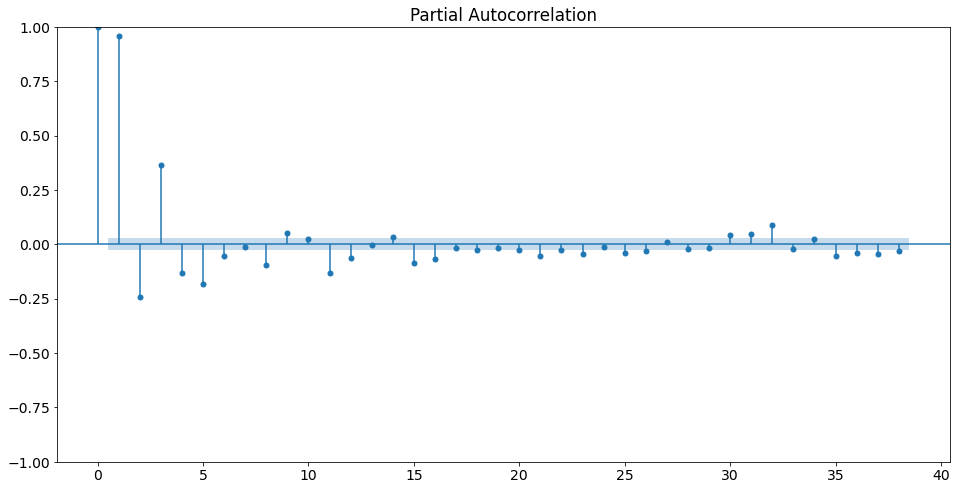

In [44]:
plot_pacf(data.pressure)

### look at seasonal part

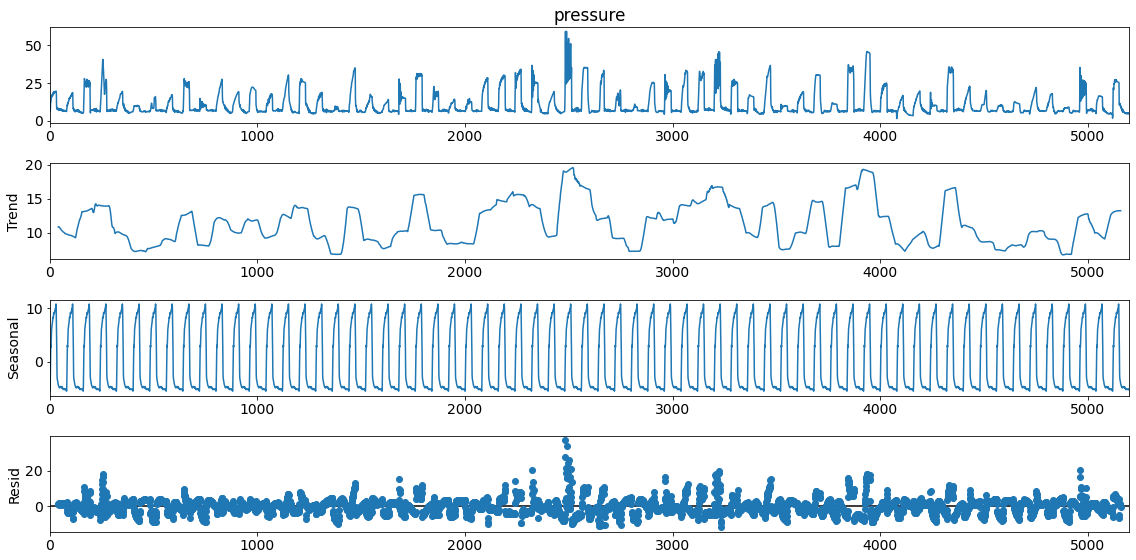

In [9]:
seas_decomp_yearly = seasonal_decompose(
    x=data.pressure,
    model='additive', 
    two_sided=True,
    period= 80)

#2. Plot
fig= seas_decomp_yearly.plot()

In [100]:
seas_decomp_yearly.seasonal

0      -5.244758
1      -4.453808
2      -1.881892
3       1.129383
4       1.516060
          ...   
5195   -5.209864
5196   -5.045811
5197   -5.203947
5198   -5.039791
5199   -5.051442
Name: seasonal, Length: 5200, dtype: float64

arimax model parameters
(p, d, q)

seasonal order parameters
(Seasonal AR specification, Seasonal Integration order, Seasonal MA, Seasonal periodicity)

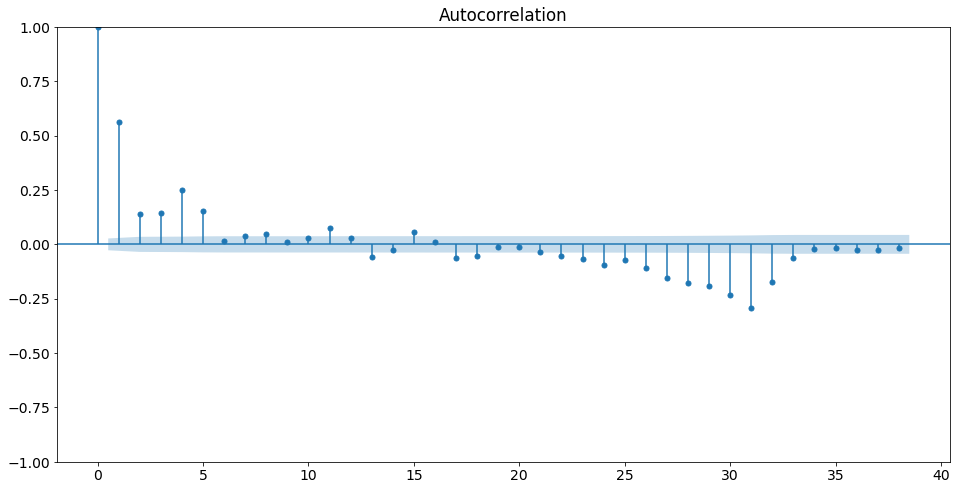

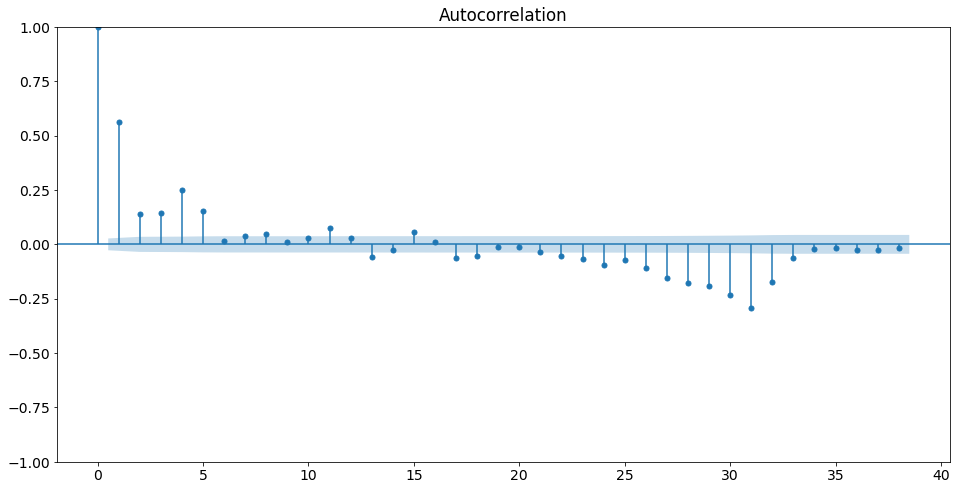

In [102]:
plot_acf(difference(seas_decomp_yearly.seasonal,1))

In [10]:
# Variables
endog = y_train
#exog = sm.add_constant(first_breath[['u_in', 'vol']])
exog = X_train

# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(3,1,3), seasonal_order=(3,1,3,80))
res = mod.fit(disp=False)
print(res.summary())

In [79]:
#predict = res.get_prediction(df.query('breath_id==2').time_step.apply(lambda x: x%80))
#predict = res.get_prediction(df.query('breath_id==2').reset_index(drop=True).index)
predict = res.get_prediction()
predict_ci = predict.conf_int()

predict_train = res.predict(start=0, end=splitpoint, exog=X_train)
#predict_dy = res.predict(start=splitpoint, end=endpoint+1, exog=X_test) # problem with shape
predict_dy = res.predict(start=splitpoint, end=end_point+1, exog=X_test, dynamic=True) # problem with shape
#predict_dy = res.forecast(exog=X_test)
#predict_dy_ci = predict_dy.conf_int()

In [37]:
print(end_point-splitpoint+1, X_test.shape)

80 (80, 9)


In [33]:
X_test.shape

(80, 9)

In [34]:
predict_dy.shape

(5121,)

In [22]:
X_train.shape

(5121, 9)

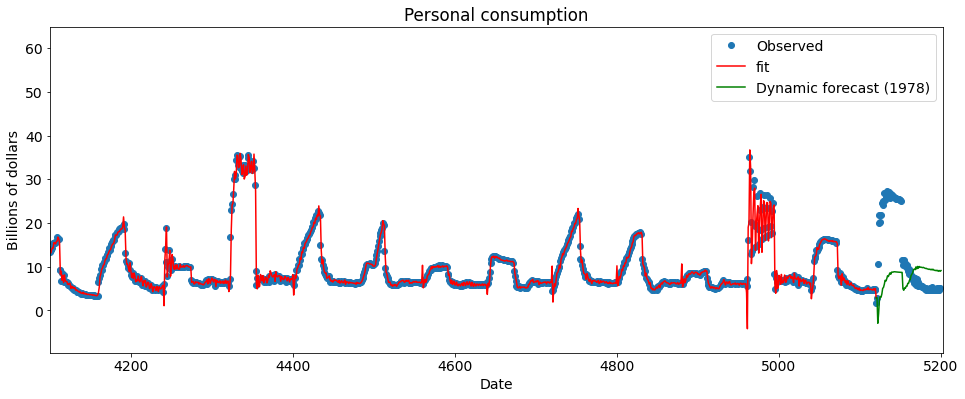

In [80]:
fig, ax = plt.subplots(figsize=(16,6))
npre = 4
ax.set(title='Personal consumption', xlabel='Date', ylabel='Billions of dollars')

# Plot data points
data.pressure.plot(ax=ax, style='o', label='Observed')

# Plot predictions
#predict.predicted_mean.plot(ax=ax, style='r--', label='One-step-ahead forecast')
#ci = predict_ci.time_step
#ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

predict_train.plot(ax=ax, style='r', label='fit')
predict_dy.plot(ax=ax, style='g', label='Dynamic forecast (1978)')
#ci = predict_dy_ci.loc['1977-07-01':]
#ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)
plt.xlim(4100,5202)
#plt.xlim(5100,5202)
legend = ax.legend(loc='upper right')

### checking for stationarity

In [1]:
## check stationarity with augmented dickey fuller test
adf_result = adfuller(df.pressure)
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
	print('\t%s: %.3f' % (key, value))

NameError: name 'adfuller' is not defined

In [ ]:
## check stationarity with augmented dickey fuller test on logarithmic pressure data
adf_result = adfuller(np.log(data.pressure))
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.231383
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


a p value of zero means that we reject the null hypothesis. in this case the null hypothesis is that there is a unit root present in the data, i.e. the series is not stationary.
thus we conclude that the series is stationary

### forecasting with the var model

In [ ]:
uniqR5C50=df.query('R==5 & C==50').breath_id.unique()

b1=df.query('R==5 & C==50')[df.breath_id==uniqR5C50[0]]
b2=df.query('R==5 & C==50')[df.breath_id==uniqR5C50[1]]

/var/folders/fx/jr2m6h953_103f1b248p3r6h0000gn/T/ipykernel_17360/2880731788.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  b1=df.query('R==5 & C==50')[df.breath_id==uniqR5C50[0]]
/var/folders/fx/jr2m6h953_103f1b248p3r6h0000gn/T/ipykernel_17360/2880731788.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  b2=df.query('R==5 & C==50')[df.breath_id==uniqR5C50[1]]


In [ ]:
model = VAR(endog=b1[['time_step', 'pressure']])
model_fit = model.fit()
print(model_fit.params)
prediction = model_fit.forecast(model_fit.L1.pressure)

              time_step  pressure
const          0.033184  2.648803
L1.time_step   0.997838  2.661766
L1.pressure    0.000164  0.752317


/Users/martin/Projects/CapStone/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AttributeError: 'VARResults' object has no attribute 'L1'